In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("data/winequality-white.csv"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
red_wine = pd.read_csv("data/winequality-white.csv", delimiter = ';')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [8]:
normalize_col = [col for col in red_wine.columns if col != "quality" and red_wine[col].max() > 1]
normalize_col

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [9]:
# Normalize the data
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Create column transformer
ct = make_column_transformer(
    (MinMaxScaler(), normalize_col)
)

# Create X & y
X = red_wine.drop("quality", axis=1)
y = red_wine["quality"]

# Build our train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

# Fit the column transformer to our training data
ct.fit(X_train)

# Transform training & test data with normalization (MinMaxScaler)
X_train_normalized = ct.transform(X_train)
X_test_normalized = ct.transform(X_test)

In [10]:
X_train_normalized

array([[0.49367089, 0.16666667, 0.24698795, ..., 0.58181818, 0.25882353,
        0.32258065],
       [0.43037975, 0.1372549 , 0.15662651, ..., 0.5       , 0.29411765,
        0.51612903],
       [0.44303797, 0.11764706, 0.22289157, ..., 0.28181818, 0.22352941,
        0.19354839],
       ...,
       [0.41772152, 0.16666667, 0.19277108, ..., 0.49090909, 0.24705882,
        0.40322581],
       [0.39240506, 0.14705882, 0.1686747 , ..., 0.41818182, 0.38823529,
        0.20967742],
       [0.26582278, 0.20588235, 0.15060241, ..., 0.32727273, 0.23529412,
        0.83870968]])

In [16]:
## Build a neural network model to fit our normalized data
import tensorflow as tf

# Set random seed
tf.random.set_seed(18)

# 1. Create the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, activation='relu', input_shape=[10]),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1)

    ]
)

# 2. Compile the model
model.compile(
    loss="mse",
    optimizer="adam"
)

# 3. Create a callback using Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(    
    min_delta=0, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# 4. Fit our model
model.fit(
     X_train_normalized,
     y_train,
     validation_data=(X_test_normalized, y_test),
     epochs=1000,
     callbacks=[callback],
 )

Epoch 1/1000
123/123 [==============================] - 2s 8ms/step - loss: 2.5081 - val_loss: 0.7077
Epoch 2/1000
123/123 [==============================] - 1s 6ms/step - loss: 0.7103 - val_loss: 0.6107
Epoch 3/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.6320 - val_loss: 0.5480
Epoch 4/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.5583 - val_loss: 0.5173
Epoch 5/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.5689 - val_loss: 0.5219
Epoch 6/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.5599 - val_loss: 0.5390
Epoch 7/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.5861 - val_loss: 0.5080
Epoch 8/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.5301 - val_loss: 0.5652
Epoch 9/1000
123/123 [==============================] - 1s 6ms/step - loss: 0.5397 - val_loss: 0.5177
Epoch 10/1000
123/123 [==============================] - 1s 5ms/step - loss: 0.534

Text(0.5, 0, 'epochs')

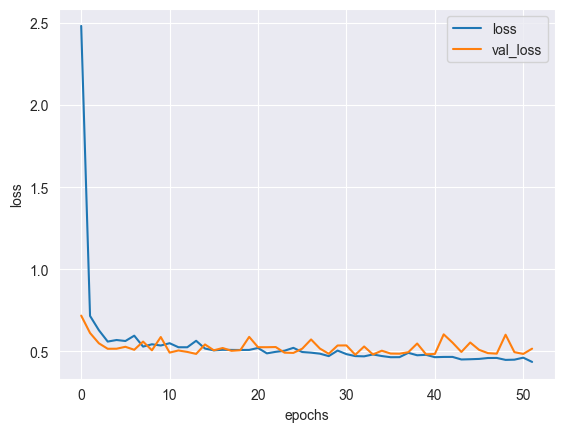

In [17]:
# plot history
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [8]:
# Evaluate the larger model
model.evaluate(X_test_normalized, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.3653


0.36526423692703247

""" 10/10 [==============================] - 0s 4ms/step - loss: 0.3679
0.36786723136901855"""